## For Colab only

In [1]:
!git clone https://github.com/maftukh/news_classifier.git

Cloning into 'news_classifier'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 36 (delta 13), reused 18 (delta 6), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [2]:
!ls news_classifier/

bert_classification_model.ipynb		      data     evals.py  optim.py
bert_classification_model_with_modules.ipynb  data.py  model.py  README.md


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Fix the path to get the correct model
!mkdir ./news_classifier/model/
!cp /content/gdrive/MyDrive/data/news_cat/model/finetuned_pytorch_model_32_ep5.bin ./news_classifier/model/

## Imports

In [1]:
!pip install pytorch-pretrained-bert

You should consider upgrading via the '/home/saydash/skoltech/.venv/bin/python -m pip install --upgrade pip' command.


In [11]:
import os
import json
import sys
import random
from pathlib import Path

# Third-party packages
import numpy as np
import pandas as pd
from pytorch_pretrained_bert.tokenization import BertTokenizer
import torch
from tqdm.notebook import tqdm, trange

sys.path.append('/content/news_classifier')

# Custom imports
import model
import data
import evals
import optim



In [2]:
# To make sure custom modules are up-to-date by the time of each call
%load_ext autoreload
%autoreload 2

## Model Parameters

In [3]:
DATA_PATH = Path('data/')
MODEL_PATH = Path('model/')

args = {
    "data_dir": DATA_PATH,
    "output_dir": MODEL_PATH,
    "ckpt_name": 'pretrain.ckpt', # Файл с которого хочется продолжить обучение
    
    "task_name": "news_cat_label",
    "bert_model": 'bert-base-uncased',  # оптимальная моделька с точки зрения веса, вряд ли стоит менять
    "do_lower_case": True,
    
    "max_seq_length": 32, # Сколько слов из колонки 'text' используется в модели
    "batch_size": 128, # размер батча на входе в модель
    'eval_steps': 500, # Через сколько шагов делать промежуточную оценку модели
    
    "learning_rate": 3e-5,
    "num_train_epochs": 5.0,
    "warmup_proportion": 0., # При .1 - первые 10% шагов обучения будут плавными, чтоб избежать взрыва градиентов 

    "no_cuda": False, # Если есть cuda, но почему-то не хочешь юзать
    "seed": 42,
}



In [4]:
def set_random_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [5]:
# Setup GPU parameters
args['device'] = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")

set_random_seeds(args['seed'])

In [6]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
args['logger'] = logging.getLogger(__name__)

In [7]:
# args['label_list'] = np.sort(df.category.unique()) - в будущем для обучения лучше так. У меня просто модель со след списком обучилась:
args['label_list'] = ['ENTERTAINMENT', 'WORLD NEWS', 'OTHER', 'POLITICS', 'WOMEN', 'SPORTS',
       'BUSINESS', 'TRAVEL', 'TECH', 'RELIGION', 'SCIENCE', 'ARTS', 'STYLE',
       'ENVIRONMENT', 'FOOD & DRINK', 'HEALTHY LIVING', 'HOME & LIVING',
       'MONEY']
args['num_labels'] = len(args['label_list'])
args['num_labels'], args['label_list']    

(18,
 ['ENTERTAINMENT',
  'WORLD NEWS',
  'OTHER',
  'POLITICS',
  'WOMEN',
  'SPORTS',
  'BUSINESS',
  'TRAVEL',
  'TECH',
  'RELIGION',
  'SCIENCE',
  'ARTS',
  'STYLE',
  'ENVIRONMENT',
  'FOOD & DRINK',
  'HEALTHY LIVING',
  'HOME & LIVING',
  'MONEY'])

In [8]:
processor = data.LabelTextProcessor(args['data_dir'], labels=args['label_list'])
tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

04/11/2022 11:36:32 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/saydash/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


### Prepare model

In [9]:
fname = "finetuned_pytorch_model_32_ep5.bin"
output_model_file = os.path.join(args['output_dir'], fname)

bert_model = model.get_model(model_path=output_model_file, 
                             bert_model=args['bert_model'], 
                             num_labels=args['num_labels'])
bert_model.to(args['device'])

04/11/2022 11:36:33 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/saydash/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/11/2022 11:36:33 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/saydash/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpakw4qowg
04/11/2022 11:36:36 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

## Make predictions on new data

### Preprocess data

In [ ]:
# df_test = pd.read_csv(os.path.join('/content/gdrive/MyDrive/data/news_cat', 'Query Results.csv'))
# df_test = df_test.fillna('')
# df_test['text'] = df_test.title + ' ' + df_test.description
# df_test.to_csv(os.path.join(args['data_dir'], 'new_test.csv'))
# df_test.head()

,id,title,description,Main,Tags,tag_num,text
0,2090,Biodiversity: What is it and how are we protec...,The planet is experiencing its sixth mass exti...,World,"Entertainment,UK,World",3,Biodiversity: What is it and how are we protec...
1,2091,Amazon union election: Will this former worker...,Workers in three Amazon warehouses are decidin...,World,"Entertainment,UK,World",3,Amazon union election: Will this former worker...
2,2092,Ukraine crisis: Why India is buying more Russi...,Imports of cheaper Russian oil by India are ri...,World,"Entertainment,UK,World",3,Ukraine crisis: Why India is buying more Russi...
3,2093,French election: Why the small town of Moissac...,The relationship between a Bulgarian community...,World,"Entertainment,UK,World",3,French election: Why the small town of Moissac...
4,2096,Roman Abramovich suffered 'suspected poisoning...,The billionaire had sore eyes and peeling skin...,World,"Entertainment,UK,World",3,Roman Abramovich suffered 'suspected poisoning...


<AxesSubplot:>

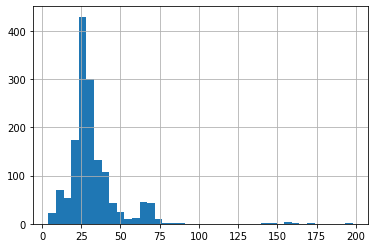

In [10]:
# Норм - многое даже укладывается в 32 слова
df_test = pd.read_csv(os.path.join(args['data_dir'], 'new_test.csv'), index_col=0)
df_test.text.str.split().str.len().hist(bins=40)

### Predict

In [13]:
# Results - "вероятности" классов
# Raw_logits - скоры для каждого класса (которые затем превращены в "вероятности" с помощью софтмакса)
# embeddings - эмбеддинги (сжатые представления) текстов в векторном виде (размерность 768; если много, можно в условный PCA закинуть и понизить размерность)
result, raw_logits, embeddings = evals.predict(bert_model, 'new_test.csv', processor, tokenizer, args)

Prediction Iteration:   0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
df_preds = df_test.copy()
df_preds['predicted'] = result.columns[result.values.argmax(axis=1)]
df_preds

,id,title,description,Main,Tags,tag_num,text,predicted
0,2090,Biodiversity: What is it and how are we protec...,The planet is experiencing its sixth mass exti...,World,"Entertainment,UK,World",3,Biodiversity: What is it and how are we protec...,ENVIRONMENT
1,2091,Amazon union election: Will this former worker...,Workers in three Amazon warehouses are decidin...,World,"Entertainment,UK,World",3,Amazon union election: Will this former worker...,BUSINESS
2,2092,Ukraine crisis: Why India is buying more Russi...,Imports of cheaper Russian oil by India are ri...,World,"Entertainment,UK,World",3,Ukraine crisis: Why India is buying more Russi...,WORLD NEWS
3,2093,French election: Why the small town of Moissac...,The relationship between a Bulgarian community...,World,"Entertainment,UK,World",3,French election: Why the small town of Moissac...,WORLD NEWS
4,2096,Roman Abramovich suffered 'suspected poisoning...,The billionaire had sore eyes and peeling skin...,World,"Entertainment,UK,World",3,Roman Abramovich suffered 'suspected poisoning...,WORLD NEWS
...,...,...,...,...,...,...,...,...
1486,2313,Second 'black box' found in China Eastern plan...,The second “black box” has been recovered from...,NaN,World,1,Second 'black box' found in China Eastern plan...,WORLD NEWS
1487,2314,Biden calls for Western unity as Russia suffer...,President Joe Biden called on the world to uni...,NaN,World,1,Biden calls for Western unity as Russia suffer...,POLITICS
1488,2315,"Russian forces damage Holocaust memorial site,...",Russian forces fired on and damaged the Drobit...,NaN,World,1,"Russian forces damage Holocaust memorial site,...",WORLD NEWS
1489,2316,WWII created generations of trauma in their fa...,When Liz Prager O’Brien was growing up in Rhod...,NaN,World,1,WWII created generations of trauma in their fa...,POLITICS


In [ ]:
df_preds.to_csv(os.path.join(args['data_dir'], 'test_preds.csv'), index=None)
result.to_csv(os.path.join(args['data_dir'], 'result.csv'), index=None)
pd.DataFrame(raw_logits).to_csv(os.path.join(args['data_dir'], 'raw_logits.csv'), index=None)
pd.DataFrame(embeddings).to_csv(os.path.join(args['data_dir'], 'embeddings.csv'), index=None)

## Json-to-json interface

In [12]:
fname = 'data/example.json'
with open(fname, 'r') as f:
    query = f.read()
json.loads(query)

[{'title': 'News title', 'text': 'News text', 'id': 12345},
 {'title': 'News title', 'text': 'News text', 'id': 12345},
 {'title': 'News title', 'text': 'News text', 'id': 12345},
 {'title': 'News title', 'text': 'News text', 'id': 12345},
 {'title': 'News title', 'text': 'News text', 'id': 12345},
 {'title': 'News title', 'text': 'News text', 'id': 12345}]

In [13]:
res = evals.predict_json(query, bert_model, processor, tokenizer, args)

Prediction Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
json.loads(res)

[{'id': 12345,
  'ENTERTAINMENT': 0.0816300064,
  'WORLD NEWS': 0.0006147406,
  'OTHER': 0.8685216904,
  'POLITICS': 0.0382830948,
  'WOMEN': 0.002730184,
  'SPORTS': 0.0014451181,
  'BUSINESS': 0.0010085765,
  'TRAVEL': 0.0001468311,
  'TECH': 0.000203285,
  'RELIGION': 0.0007750434,
  'SCIENCE': 0.0001162445,
  'ARTS': 0.0004412504,
  'STYLE': 0.0012045999,
  'ENVIRONMENT': 0.0009753357,
  'FOOD & DRINK': 0.0001700497,
  'HEALTHY LIVING': 0.0014444471,
  'HOME & LIVING': 0.00013015,
  'MONEY': 0.0001593335},
 {'id': 12345,
  'ENTERTAINMENT': 0.0816300064,
  'WORLD NEWS': 0.0006147406,
  'OTHER': 0.8685216904,
  'POLITICS': 0.0382830948,
  'WOMEN': 0.002730184,
  'SPORTS': 0.0014451181,
  'BUSINESS': 0.0010085765,
  'TRAVEL': 0.0001468311,
  'TECH': 0.000203285,
  'RELIGION': 0.0007750434,
  'SCIENCE': 0.0001162445,
  'ARTS': 0.0004412504,
  'STYLE': 0.0012045999,
  'ENVIRONMENT': 0.0009753357,
  'FOOD & DRINK': 0.0001700497,
  'HEALTHY LIVING': 0.0014444471,
  'HOME & LIVING': 0.0001